#### Лаба 3

#### задачи траекторного управления

### Given

In [313]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Math
import inspect
import bisect



In [4]:
# robot model parameters
m = 2.8 # in kg
J = 3 # in kg*m

In [224]:
x, y, omega, alpha, alpha_asterisk, vx, vy, Fx, Fy, M  = sm.symbols("x y omega alpha alpha_asterisk vx vy Fx Fy M")
A = sm.Matrix( [[1/m,0,0],[0,1/m,0],[0,0,1/J]] )
z = sm.Matrix( [[vx],[vy],[omega]] ) # in m frame
u = sm.Matrix( [[Fx],[Fy],[M]] )
R = sm.Matrix( [[sm.cos(alpha),sm.sin(alpha)],[-sm.sin(alpha),sm.cos(alpha)]] ) # from mobile to base

In [229]:
def display_expr(expr):
    frame = inspect.currentframe()
    frame = inspect.getouterframes(frame)[1]
    string = inspect.getframeinfo(frame[0]).code_context[0].strip()
    args = string[string.find('(') + 1:-1].split(',')
    
    names = []
    for i in args:
        if i.find('=') != -1:
            names.append(i.split('=')[1].strip())
        else:
            names.append(i)
    if names[0]=='phi_1':
        names[0] = '\\varphi_1'
    if names[0]=='phi_2':
        names[0] = '\\varphi_2'
    if names[0]=='phi_3':
        names[0] = '\\varphi_3'
    if names[0]=='vm':
        names[0] = 'v_m'
    if names[0]=='vb':
        names[0] = 'v_b'
    if names[0]=='dots':
        names[0] = '\\dot s'
    if names[0]=='dote':
        names[0] = '\\dot e'

    expr = expr.xreplace({n : round(n, 3) for n in expr.atoms(sm.Number)})
    str = sm.latex(expr)
    # str = str.replace('\\theta','\\vartheta')
    str = str.replace('vx','v_x')
    str = str.replace('vy','v_y')
    str = str.replace('Fx','F_x')
    str = str.replace('Fy','F_y') 
    str = str.replace('\\alpha_{asterisk}','\\alpha^{*}')

    display(Math(names[0] + '=' + str))    

In [7]:
Au = A*u
display_expr(Au)

<IPython.core.display.Math object>

In [233]:
vm = sm.Matrix([[vx],[vy]])
display_expr(vm)
vb = R*vm
display_expr(vb)
dots = (sm.transpose(R.subs(alpha,alpha_asterisk))*vb)[0]
display_expr(dots)
dote = (sm.transpose(R.subs(alpha,alpha_asterisk))*vb)[1]
display_expr(dote)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
a = (1/m)*sm.transpose(R)*sm.Matrix([[Fx],[Fy]])
display_expr(a)

<IPython.core.display.Math object>

### Traj phi

In [168]:
#trajectory
x0 = -7
y0 = 4
alpha0 = 3*np.pi/4
vs_des1 = 1 
vs_des2 = 3
vs_des3 = 5

R1 = 3
xc1 = -3
yc1 = 2
R3 = 5
xc3 = 12
yc3 = 2
phi_1 = (x-xc1)**2+(y-yc1)**2-R1**2
phi_2 = -2*sm.cos(0.5*x+0.3)+y-2
phi_3 = (x-xc3)**2 + (y-yc3)**2 - R3**2
display_expr(phi_1)
display_expr(phi_2)
display_expr(phi_3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [169]:
calc_phi_1_y = sm.solve(phi_1, y)
display(Math(sm.latex(calc_phi_1_y)))

<IPython.core.display.Math object>

In [170]:
calc_phi_2_y = sm.solve(phi_2, y)
display(Math(sm.latex(calc_phi_2_y)))

<IPython.core.display.Math object>

In [171]:
calc_phi_3_y = sm.solve(phi_3, y)
display(Math(sm.latex(calc_phi_3_y)))

<IPython.core.display.Math object>

### Traj calc

In [172]:
params = tuple(calc_phi_1_y[0].free_symbols)
print(params)
fun_calc_phi_11_y = sm.lambdify(params, calc_phi_1_y[0], modules='numpy')
params = tuple(calc_phi_1_y[1].free_symbols)
print(params)
fun_calc_phi_12_y = sm.lambdify(params, calc_phi_1_y[1], modules='numpy')

params = tuple(calc_phi_2_y[0].free_symbols)
print(params)
fun_calc_phi_2_y = sm.lambdify(params, calc_phi_2_y[0], modules='numpy')

params = tuple(calc_phi_3_y[0].free_symbols)
print(params)
fun_calc_phi_31_y = sm.lambdify(params, calc_phi_3_y[0], modules='numpy')
params = tuple(calc_phi_3_y[1].free_symbols)
print(params)
fun_calc_phi_32_y = sm.lambdify(params, calc_phi_3_y[1], modules='numpy')

(x,)
(x,)
(x,)
(x,)
(x,)


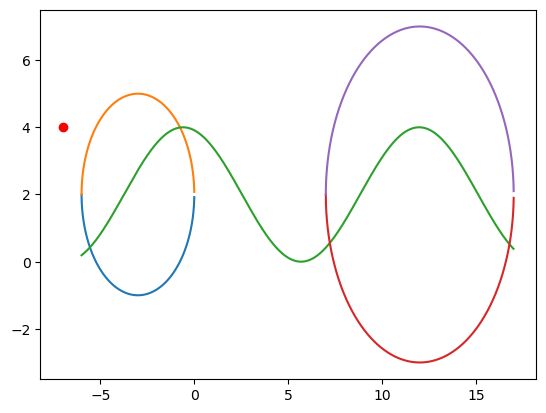

In [173]:
x1 = np.arange(xc1-R1,xc1+R1,1e-3)
x2 = np.arange(-6,17,1e-2)
x3 = np.arange(xc3-R3,xc3+R3,1e-3)
plt.plot(x1,fun_calc_phi_11_y(x1))
plt.plot(x1,fun_calc_phi_12_y(x1))
plt.plot(x2,fun_calc_phi_2_y(x2))
plt.plot(x3,fun_calc_phi_31_y(x3))
plt.plot(x3,fun_calc_phi_32_y(x3))
plt.plot(x0,y0,"or")

In [174]:
#поиск точек переключений
def calc_fun_optim_finding_x(x):
    return (fun_calc_phi_12_y(x)-fun_calc_phi_2_y(x))**2
xsw1 = sp.optimize.minimize_scalar(calc_fun_optim_finding_x,bounds=(xc1-R1,xc1+R1),method='bounded').x
print(xsw1)

-0.7583442022818133


In [175]:
def calc_fun_optim_finding_x(x):
    return (fun_calc_phi_2_y(x)-fun_calc_phi_31_y(x))**2
xsw2 = sp.optimize.minimize_scalar(calc_fun_optim_finding_x,bounds=(xc3,xc3+R3),method='bounded').x
print(xsw2)
xsw3 = xc3-R3

16.775623130982034


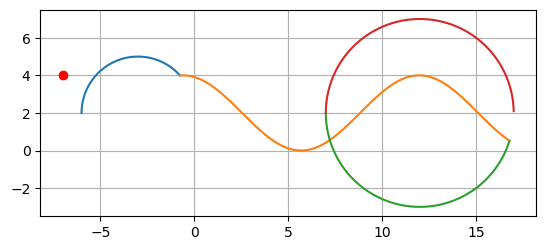

In [244]:
# desired traj
x1 = np.arange(xc1-R1,xsw1,1e-3)
x2 = np.arange(xsw1,xsw2,1e-2)
x3 = np.arange(xsw3,xsw2,1e-3)
x4 = np.arange(xsw3,xc3+R3,1e-3)
plt.plot(x1,fun_calc_phi_12_y(x1))
plt.plot(x2,fun_calc_phi_2_y(x2))
plt.plot(x3,fun_calc_phi_31_y(x3))
plt.plot(x4,fun_calc_phi_32_y(x4))
plt.plot(x0,y0,"or")
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

### S calc

In [307]:
def s_1(x):
    return (np.pi - np.arccos((x-xc1)/R1) )*R1

In [206]:
# compute s paths
L_2 = sm.sqrt( 1 + ( sm.diff(calc_phi_2_y[0],x) )**2 )
display_expr(L_2)

params = tuple(L_2.free_symbols)
calc_s_2_int = sm.lambdify(params, L_2, modules='numpy')

def s_2(x):
    return sp.integrate.quad(calc_s_2_int,xsw1,x)[0]

<IPython.core.display.Math object>

In [416]:
def s_3(x):
    return np.arccos((x-xc3)/R3)*R3 - np.arccos((xsw2-xc3)/R3)*R3
def s_4(x):
    return (np.pi - np.arccos((x-xc3)/R3) )*R3

### finding $s_0$

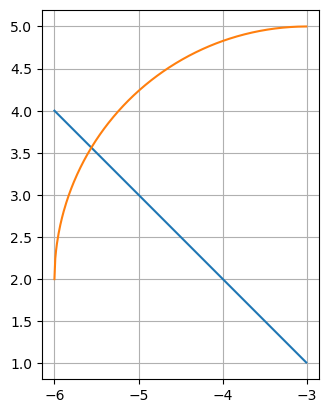

In [254]:
t_data = np.arange(xc1-R1,xc1,1e-2)
plt.plot(t_data,(t_data-(xc1-R1))*np.tan(alpha0 - np.pi) + y0)
plt.plot(t_data,fun_calc_phi_12_y(t_data))
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [255]:
# finding s0
def fun_optim_s0(x):
    return ( (x-(xc1-R1))*np.tan(alpha0 - np.pi) + y0 - fun_calc_phi_12_y(x) )**2

x0_4s0 = sp.optimize.minimize_scalar(fun_optim_s0,bounds=(xc1-R1,xc1),method='bounded').x
s0 = s_1(x0_4s0)
print(x0_4s0)
print(s0)

-5.561554301636298
1.6423682554168426


In [463]:
s_len = s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3) + s_4(xc3+R3)
print(s_len)
s_all = [0,s_1(xsw1),s_1(xsw1) + s_2(xsw2),s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3),s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3) + s_4(xc3+R3)]
print(s_all)
print(s_all[2]-s_all[1])
print(s_all[3]-s_all[2])
print(s_all[4]-s_all[3])

58.64969623920736
[0, 7.243989865398947, 28.737350135440845, 42.94173297125839, 58.64969623920736]
21.493360270041897
14.204382835817544
15.70796326794897


### control

$\Upsilon(x,y)$ = $\begin{bmatrix} \frac{\partial \psi(x,y)}{\partial x} & \frac{\partial \psi(x,y)}{\partial y} \\ & \\\frac{\partial \varphi(x,y)}{\partial x} & \frac{\partial \varphi(x,y)}{\partial y} \end{bmatrix}$

In [496]:
# calc alpha_asterisk
s = sm.symbols("s")
phi_12_x = sm.solve( ( sm.pi - sm.acos((x-xc1)/R1) )*R1 - s , x)[0] 
params = tuple(phi_12_x.free_symbols)
calc_phi_1_x = sm.lambdify(params, phi_12_x, modules='numpy')

dotphi_1 = sm.diff(calc_phi_1_y[1],x)
params = tuple(dotphi_1.free_symbols)
calc_dotphi_1 = sm.lambdify(params, dotphi_1, modules='numpy')

def fun_optim_s2_x(x,s):
    return (s_2(x)-s)**2
def calc_phi_2_x(s):
    return sp.optimize.minimize(fun_optim_s2_x,(xsw1+xsw2)/2,args=s).x[0]
dotphi_2 = sm.diff(calc_phi_2_y[0],x)
params = tuple(dotphi_2.free_symbols)
calc_dotphi_2 = sm.lambdify(params, dotphi_2, modules='numpy')

phi_3_x = sm.solve( (sm.acos((x-xc3)/R3))*R3 - (sm.acos((xsw2-xc3)/R3))*R3 - s , x )[0] 
params = tuple(phi_3_x.free_symbols)
calc_phi_3_x = sm.lambdify(params, phi_3_x, modules='numpy')

dotphi_3 = sm.diff(calc_phi_3_y[0],x)
params = tuple(dotphi_3.free_symbols)
calc_dotphi_3 = sm.lambdify(params, dotphi_3, modules='numpy')

phi_4_x = sm.solve( (sm.pi - sm.acos((x-xc3)/R3) )*R3 - s , x )[0] 
params = tuple(phi_4_x.free_symbols)
calc_phi_4_x = sm.lambdify(params, phi_4_x, modules='numpy')

dotphi_4 = sm.diff(calc_phi_3_y[1],x)
params = tuple(dotphi_4.free_symbols)
calc_dotphi_4 = sm.lambdify(params, dotphi_4, modules='numpy')

def calc_alpha_asterisk(s):
    if s<=0:
        val_asterisk = 1e6
    elif s>=s_all[4]:
        val_asterisk = -1e6
    elif s==s_all[3]:
        val_asterisk = 1e6
    elif s==s_all[2]:
        val_asterisk = 1.7523330864423152
    elif s==s_all[1]: 
        val_asterisk = -0.5226298800644945
    else:
        i = search_index(s)
        if i==len(s_all)-1:
            i-=1
        if i==0:
            x = calc_phi_1_x(s)
            val_asterisk = calc_dotphi_1(x)
        elif i==1:
            x = calc_phi_2_x(s-s_all[1])
            val_asterisk = calc_dotphi_2(x)
        elif i==2:
            x = calc_phi_3_x(s-s_all[2])
            val_asterisk = calc_dotphi_3(x)
        elif i==3:
            x = calc_phi_4_x(s-s_all[3])
            val_asterisk = calc_dotphi_4(x)
        
        # print(i)
        # print(x)
    return val_asterisk

def search_index(x):
    return bisect.bisect(s_all,x) - 1

# calc_alpha_asterisk((s_all[4]-s_all[3])/2+s_all[3])
# calc_alpha_asterisk(58)
# (calc_dotphi_3(calc_phi_3_x(s_all[2])) + calc_dotphi_2(calc_phi_2_x(s_all[2]-s_all[1])) ) /2
# (calc_alpha_asterisk(s_all[1]-1e-6) + calc_alpha_asterisk(s_all[1]))/2

In [ ]:
# calc curvature of second path


In [ ]:
# calc curvature
def curvature(s):
    i = search_index(s)
    if i==len(s_all)-1:
        i-=1
    if i==0:
        xi=1/R1
    elif i==1:

    else:
        xi=1/R3
    return xi

In [432]:
Vs = 5
t_all = s_all[-1]/Vs
print(t_all)

11.729939247841472


In [46]:
# Jacobian1 = sm.Matrix([[sm.diff(psi_1,x),sm.diff(phi_1,x)],[sm.diff(psi_1,y),sm.diff(phi_1,y)]])
# display_expr(Jacobian1)



# ztask = Jacobian1*zm
# display_expr(ztask)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [47]:
params = tuple(ztask.free_symbols)
print(params)
fun_calc_ztask = sm.lambdify(params, ztask, modules='numpy')

params = tuple(phi_1.free_symbols)
print(params)
fun_calc_phi_1 = sm.lambdify(params, phi_1, modules='numpy')

(y, alpha, x)
(x, y)


In [49]:
x_data = 1
y_data = 2
print(fun_calc_ztask(x_data,0,y_data))
print(fun_calc_phi_1(x0,y0))

[[8.8]
 [0.4]]
11
